In [1]:
import pandas as pd
import networkx as nx
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

import con_score

Load data

In [2]:
df = pd.read_csv("../output/Survivor/vote_history.csv")
df = df[df.version == "US"]
df['castaway_uid']  = df['season'].astype(str) + df['castaway']
df['vote_uid']  = df['season'].astype(str) + df['vote']
df = df.dropna(subset=['vote'])

In [3]:
castaways = pd.read_csv("../output/Survivor/castaways.csv")
castaways = castaways[castaways.version == "US"]
castaways['castaway_uid']  = castaways['season'].astype(str) + castaways['castaway']
castaways = castaways[['castaway_uid', 'result']]
castaways = castaways[castaways.castaway_uid.isin(df['castaway_uid'].unique().tolist() + df['vote_uid'].unique().tolist())]
cats = ['Sole Survivor', 'Runner-up', '2nd runner-up', '15th voted out', '14th voted out', '13th voted out', 
        '12th voted out', '11th voted out', '10th voted out', '9th voted out', 
        '8th voted out', '7th voted out', '6th voted out', '5th voted out', 
        '4th voted out', '3rd voted out', '2nd voted out', '1st voted out']
castaways = castaways[castaways.result.isin(cats)]
df = df[df.castaway_uid.isin(castaways.castaway_uid.unique())]
df = df[df.vote_uid.isin(castaways.castaway_uid.unique())]

In [4]:
df.to_csv("../output/Survivor/final_vote_history.csv", index=False)
castaways.to_csv("../output/Survivor/final_castaways.csv", index=False)

Create Digraph

In [5]:
G = nx.DiGraph()
for _, row in df.iterrows():
    voter = row['castaway_uid']
    voted_against = row['vote_uid']
    if G.has_edge(voter, voted_against):
        G[voter][voted_against]['weight'] += 1
    else:
        G.add_edge(voter, voted_against, weight=1)

In [6]:
nx.find_cycle(G)

[('1.0Sonja', '1.0Rudy'), ('1.0Rudy', '1.0Sonja')]

In [7]:
n = G.number_of_nodes()
m = G.number_of_edges()
sparsity = m / (n * (n - 1))
sparsity

0.00642770483311954

In [8]:
print(nx.number_weakly_connected_components(G))
print(nx.number_strongly_connected_components(G))

46
90


In [9]:
max_diameter = 0
for component in nx.weakly_connected_components(G):
    subgraph = G.subgraph(component)
    undirected_subgraph = subgraph.to_undirected()
    diameter = nx.diameter(undirected_subgraph)
    max_diameter = max(max_diameter, diameter)
print(f"Maximum Diameter of Weakly Connected Components (Undirected): {max_diameter}")

Maximum Diameter of Weakly Connected Components (Undirected): 3


Compute CON Score, PageRank, and Outcomes

In [10]:
try:
    CON_score = pd.read_pickle('../output/Survivor/Survivor_CON_score.pkl')
except:
    CON_score = con_score.compute_con_scores(G)

In [11]:
#import pickle  
#with open('../output/Survivor/Survivor_CON_score.pkl', 'wb') as f:
#    pickle.dump(CON_score, f)

In [12]:
pagerank = nx.pagerank(G, weight='weight')

Discretize Survivor Outcomes

In [13]:
outcomes_dict = pd.read_pickle("../output/Survivor/Survivor_outcome_dict.pkl")

In [14]:
mapping = {category: len(cats) - i for i, category in enumerate(cats)}
discretized_outcomes = {key: mapping[value] for key, value in outcomes_dict.items()}

In [15]:
lst = list(discretized_outcomes.values())
lst.sort()

Create ranking dataframe

In [16]:
rank_data = []
for player in CON_score.keys():
    rank_data.append({'Player Name': player, 
                      'CON Score': CON_score[player], 
                      'PageRank': pagerank.get(player, 0), 
                      'Outcome': discretized_outcomes.get(player, 0)
                      })
rank_df = pd.DataFrame(rank_data)

In [17]:
rank_df.Outcome.describe()

count    806.000000
mean       8.631514
std        5.458091
min        0.000000
25%        4.000000
50%        8.000000
75%       13.000000
max       18.000000
Name: Outcome, dtype: float64

Calculate Spearman's Rho

In [18]:
con_score = rank_df['CON Score']
page_rank = rank_df['PageRank']
outcome = rank_df['Outcome']

rho_con_page = spearmanr(con_score, page_rank)
rho_con_Outcome = spearmanr(con_score, outcome)
rho_page_Outcome = spearmanr(page_rank, outcome)

print(f"CON Score vs. Outcome: {rho_con_Outcome}")
print(f"CON Score vs. PageRank: {rho_con_page}")
print(f"PageRank vs. Outcome: {rho_page_Outcome}")

CON Score vs. Outcome: SignificanceResult(statistic=0.767849821891632, pvalue=1.1904505106555935e-157)
CON Score vs. PageRank: SignificanceResult(statistic=0.003766870545620278, pvalue=0.914966381373771)
PageRank vs. Outcome: SignificanceResult(statistic=-0.09905043104355828, pvalue=0.004883564165565025)


In [19]:
out_degree_centrality = dict(G.out_degree(weight='weight'))
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight', normalized=True)

centrality_df = pd.DataFrame({
    'Player': list(G.nodes),
    'Out-Degree Centrality': [out_degree_centrality.get(player, 0) for player in G.nodes],
    'Closeness Centrality': [closeness_centrality.get(player, 0) for player in G.nodes],
    'Betweenness Centrality': [betweenness_centrality.get(player, 0) for player in G.nodes],
    'CON Score': [CON_score.get(player, 0) for player in G.nodes]
})

centrality_df['Outcome'] = centrality_df['Player'].map(discretized_outcomes).astype(float)

G_inverted = G.reverse(copy=True)
pagerank_centrality = nx.pagerank(G_inverted, weight='weight')
centrality_df['PageRank Centrality'] = [pagerank_centrality.get(player, 0) for player in centrality_df['Player']]

Normalize centralities

In [20]:
for col in ['Out-Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality', 'PageRank Centrality', 'CON Score', 'Outcome']:
    if col == "Outcome":
        print(centrality_df[col].max())
        print(centrality_df[col].min())
        print((centrality_df[col].max() - centrality_df[col].min()))
    centrality_df[col] = (centrality_df[col] - centrality_df[col].min()) / (centrality_df[col].max() - centrality_df[col].min())

18.0
1.0
17.0


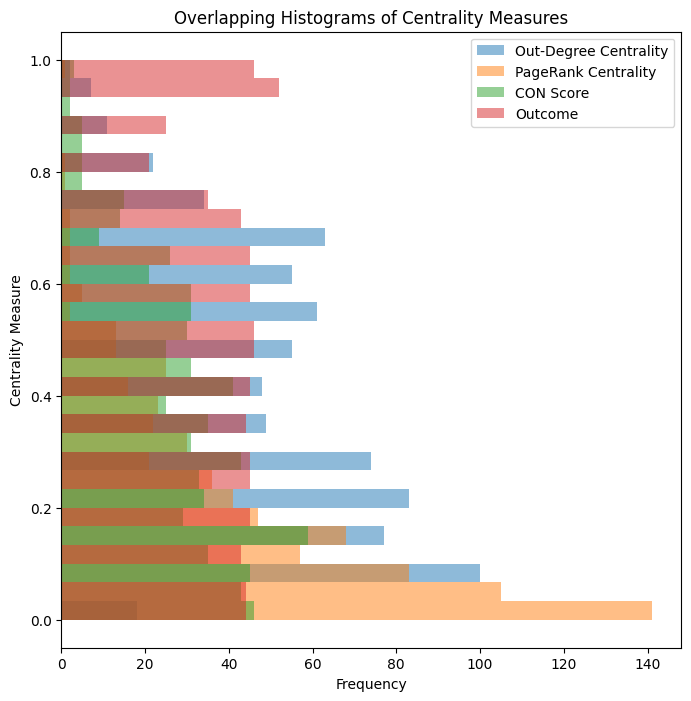

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))  
for col in ['Out-Degree Centrality', 'PageRank Centrality', 'CON Score', 'Outcome']:
    centrality_df[col].plot(kind='hist', bins=30, alpha=0.5, orientation='horizontal', ax=ax, label=col)
ax.legend()
plt.xlabel('Frequency')
plt.ylabel('Centrality Measure')
plt.title('Overlapping Histograms of Centrality Measures')
plt.show()


Plot sorted centrality matrix

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


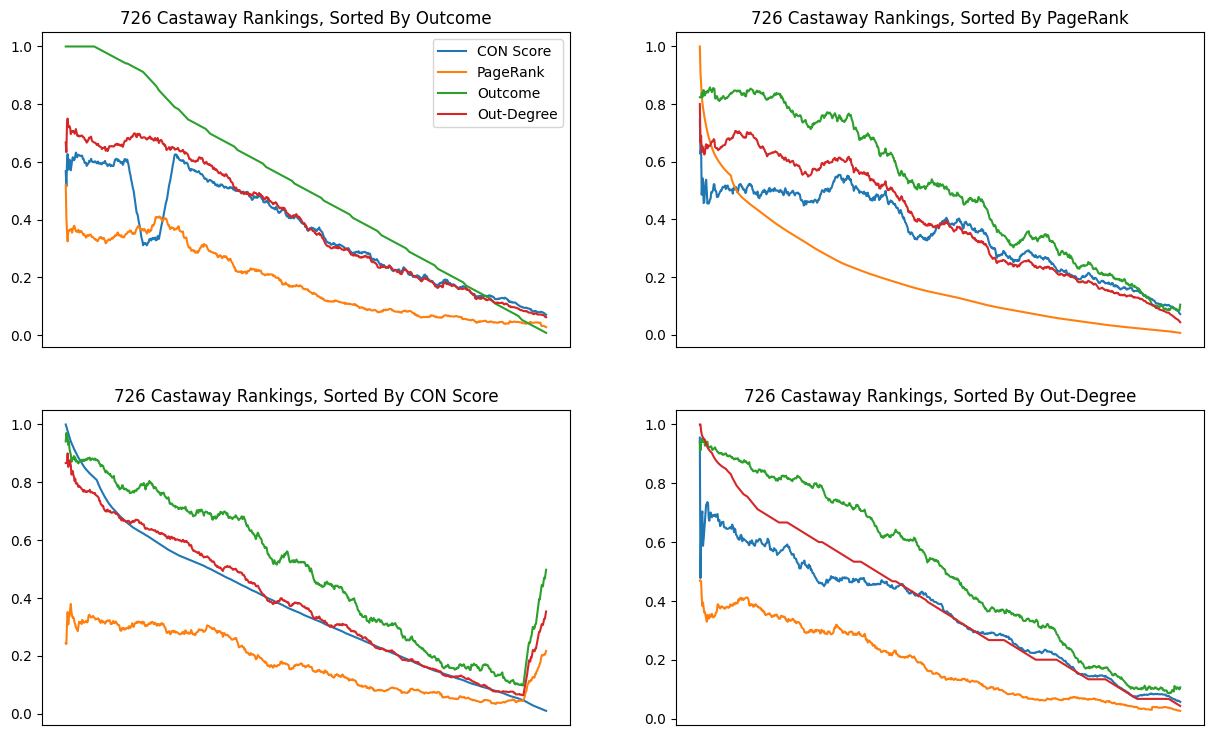

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(15, 9))

window_size = 50
def smooth_series(data, window):
    return data.rolling(window=window, min_periods=1).mean()

rank_df_small = centrality_df.sort_values('Outcome', ascending=False)
axs[0, 0].plot(rank_df_small['Player'], smooth_series(rank_df_small['CON Score'], window_size), label='CON Score')
axs[0, 0].plot(rank_df_small['Player'], smooth_series(rank_df_small['PageRank Centrality'], window_size), label='PageRank')
axs[0, 0].plot(rank_df_small['Player'], smooth_series(rank_df_small['Outcome'], window_size), label='Outcome')
axs[0, 0].plot(rank_df_small['Player'], smooth_series(rank_df_small['Out-Degree Centrality'], window_size), label='Out-Degree')
axs[0, 0].set_title('726 Castaway Rankings, Sorted By Outcome')
axs[0, 0].legend()
axs[0, 0].set_xticks([])

rank_df_small = centrality_df.sort_values('PageRank Centrality', ascending=False)
axs[0, 1].plot(rank_df_small['Player'], smooth_series(rank_df_small['CON Score'], window_size), label='CON Score')
axs[0, 1].plot(rank_df_small['Player'], smooth_series(rank_df_small['PageRank Centrality'], window_size), label='PageRank')
axs[0, 1].plot(rank_df_small['Player'], smooth_series(rank_df_small['Outcome'], window_size), label='Outcome')
axs[0, 1].plot(rank_df_small['Player'], smooth_series(rank_df_small['Out-Degree Centrality'], window_size), label='Out-Degree')
axs[0, 1].set_title('726 Castaway Rankings, Sorted By PageRank')
axs[0, 1].set_xticks([])

rank_df_small = centrality_df.sort_values('CON Score', ascending=False)
axs[1, 0].plot(rank_df_small['Player'], smooth_series(rank_df_small['CON Score'], window_size), label='CON Score')
axs[1, 0].plot(rank_df_small['Player'], smooth_series(rank_df_small['PageRank Centrality'], window_size), label='PageRank')
axs[1, 0].plot(rank_df_small['Player'], smooth_series(rank_df_small['Outcome'], window_size), label='Outcome')
axs[1, 0].plot(rank_df_small['Player'], smooth_series(rank_df_small['Out-Degree Centrality'], window_size), label='Out-Degree')
axs[1, 0].set_title('726 Castaway Rankings, Sorted By CON Score')
axs[1, 0].set_xticks([])

rank_df_small = centrality_df.sort_values('Out-Degree Centrality', ascending=False)
axs[1, 1].plot(rank_df_small['Player'], smooth_series(rank_df_small['CON Score'], window_size), label='CON Score')
axs[1, 1].plot(rank_df_small['Player'], smooth_series(rank_df_small['PageRank Centrality'], window_size), label='PageRank')
axs[1, 1].plot(rank_df_small['Player'], smooth_series(rank_df_small['Outcome'], window_size), label='Outcome')
axs[1, 1].plot(rank_df_small['Player'], smooth_series(rank_df_small['Out-Degree Centrality'], window_size), label='Out-Degree')
axs[1, 1].set_title('726 Castaway Rankings, Sorted By Out-Degree')
axs[1, 1].set_xticks([])

plt.savefig('../output/Survivor/Survivor_centrality_measures_MA_2x2_plot.eps', format='eps')
plt.show()

In [23]:
spearman_out_degree = spearmanr(centrality_df['Outcome'], centrality_df['Out-Degree Centrality'], nan_policy='omit')
spearman_closeness = spearmanr(centrality_df['Outcome'], centrality_df['Closeness Centrality'], nan_policy='omit')
spearman_betweenness = spearmanr(centrality_df['Outcome'], centrality_df['Betweenness Centrality'], nan_policy='omit')
spearman_pagerank = spearmanr(centrality_df['Outcome'], centrality_df['PageRank Centrality'], nan_policy='omit')
spearman_conscore = spearmanr(centrality_df['Outcome'], centrality_df['CON Score'], nan_policy='omit')

results = {
    'Centrality Metric': [
        'Out-Degree Centrality',
        'Closeness Centrality',
        'Betweenness Centrality',
        'PageRank Centrality',
        'CON Score'
    ],
    'Spearmans R Statistic': [
        spearman_out_degree.correlation,
        spearman_closeness.correlation,
        spearman_betweenness.correlation,
        spearman_pagerank.correlation,
        spearman_conscore.correlation
    ],
    'P-Value': [
        spearman_out_degree.pvalue,
        spearman_closeness.pvalue,
        spearman_betweenness.pvalue,
        spearman_pagerank.pvalue,
        spearman_conscore.pvalue
    ]
}

spearman_df = pd.DataFrame(results)
spearman_df.sort_values('Spearmans R Statistic', ascending=False)

,Centrality Metric,Spearmans R Statistic,P-Value
0,Out-Degree Centrality,0.898801,2.352779e-273
3,PageRank Centrality,0.824922,9.767760e-190
4,CON Score,0.720748,1.357268e-122
2,Betweenness Centrality,0.334598,2.604571e-21
1,Closeness Centrality,-0.245401,7.144948e-12


In [24]:
spearman_df.to_csv('../output/Survivor/Survivor_spearman_correlations_table.csv', index=False)